In [1]:
from keras.datasets.cifar10 import load_data

(trainX, trainy), (testX, testy) = load_data()

print('train', trainX.shape, trainy.shape)
print('train', testX.shape, testy.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step: 
train (50000, 32, 32, 3) (50000, 1)
train (10000, 32, 32, 3) (10000, 1)


In [2]:
import numpy as np

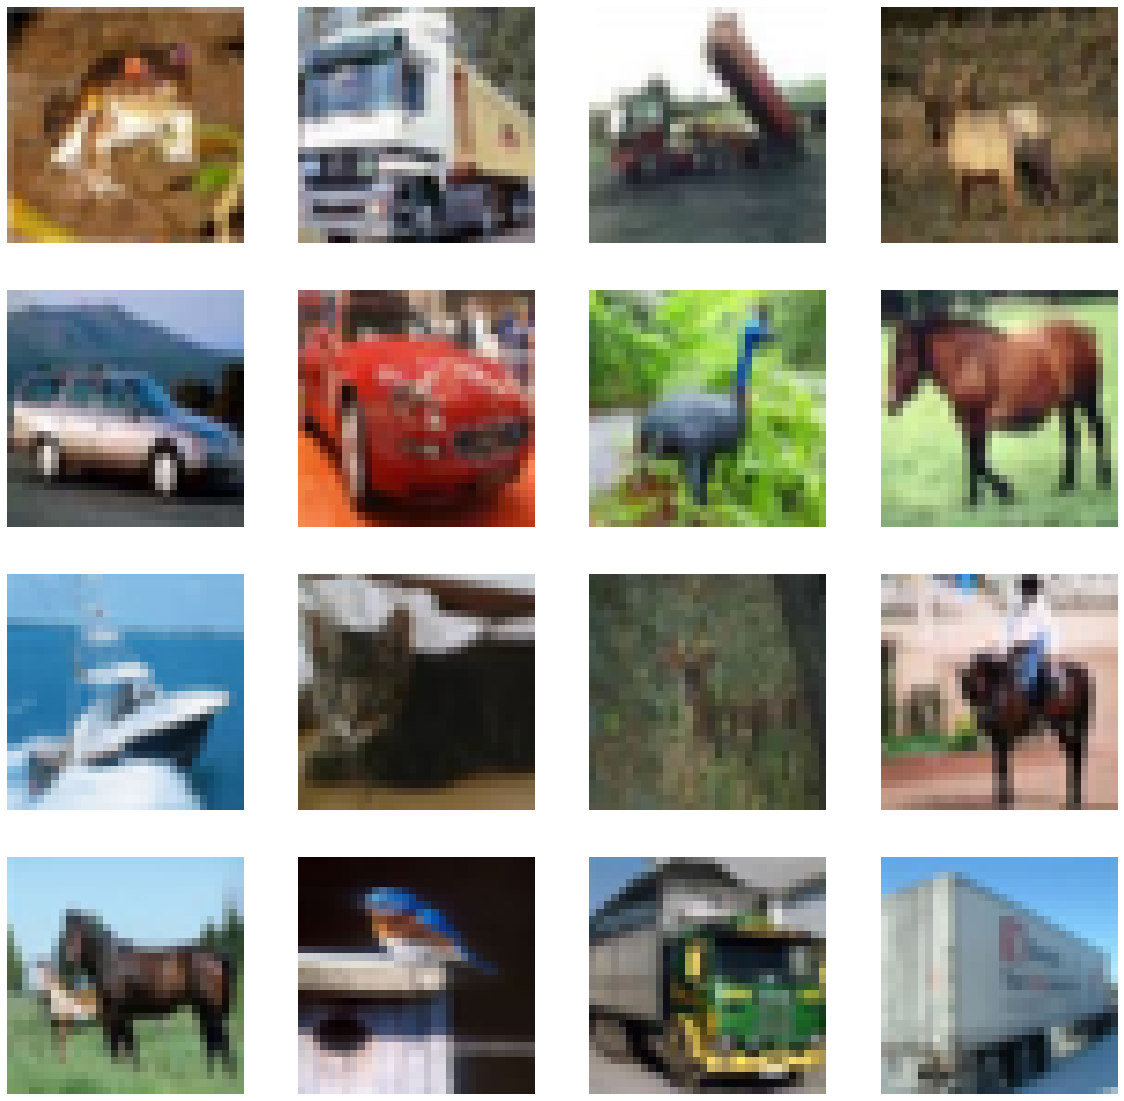

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
for i in np.arange(16):
    
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(trainX[i])

# 32 logo dataset

In [4]:
def from_s3_npy(s3_uri: str):
    bytes_ = BytesIO()
    parsed_s3 = urlparse(s3_uri)
    client.download_fileobj(
        Fileobj=bytes_, Bucket=parsed_s3.netloc, Key=parsed_s3.path[1:]
    )
    bytes_.seek(0)
    return np.load(bytes_, allow_pickle=True)

In [5]:
from io import BytesIO
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import boto3
client = boto3.client("s3")

In [6]:
c = from_s3_npy('s3://verafin-mitacs-yifu-chen/32/')

In [7]:
c=c[0:6080]

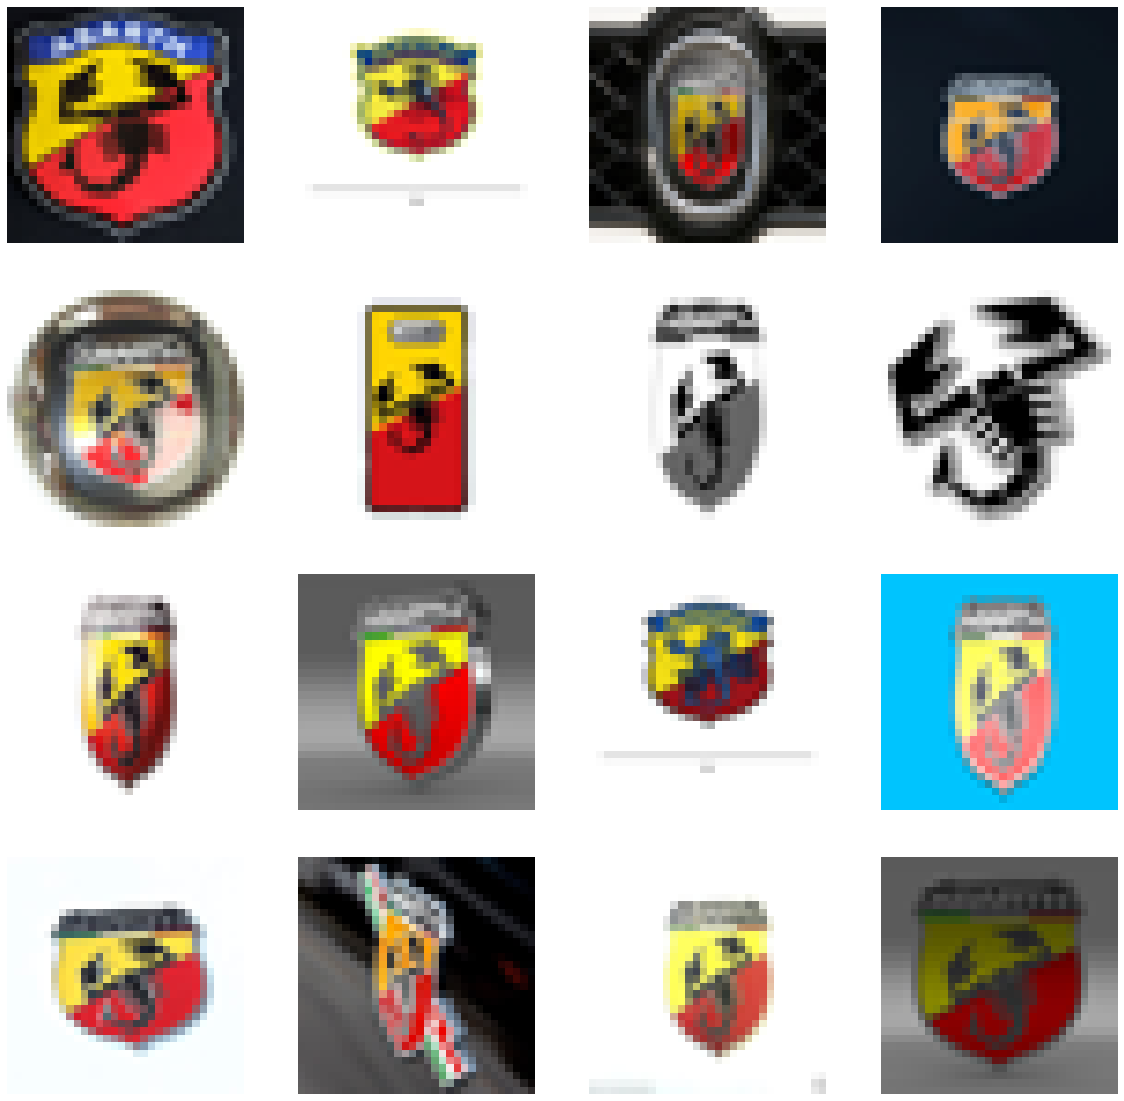

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
for i in np.arange(16):
    
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(c[i])

In [9]:
c.shape

(6080, 32, 32, 3)

# Checks

In [3]:
def from_s3_npy(s3_uri: str):
    bytes_ = BytesIO()
    parsed_s3 = urlparse(s3_uri)
    client.download_fileobj(
        Fileobj=bytes_, Bucket=parsed_s3.netloc, Key=parsed_s3.path[1:]
    )
    bytes_.seek(0)
    return np.load(bytes_, allow_pickle=True)

In [4]:
from io import BytesIO
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import boto3
client = boto3.client("s3")

In [5]:
c = from_s3_npy('s3://verafin-mitacs-yifu-chen/32_checks/')

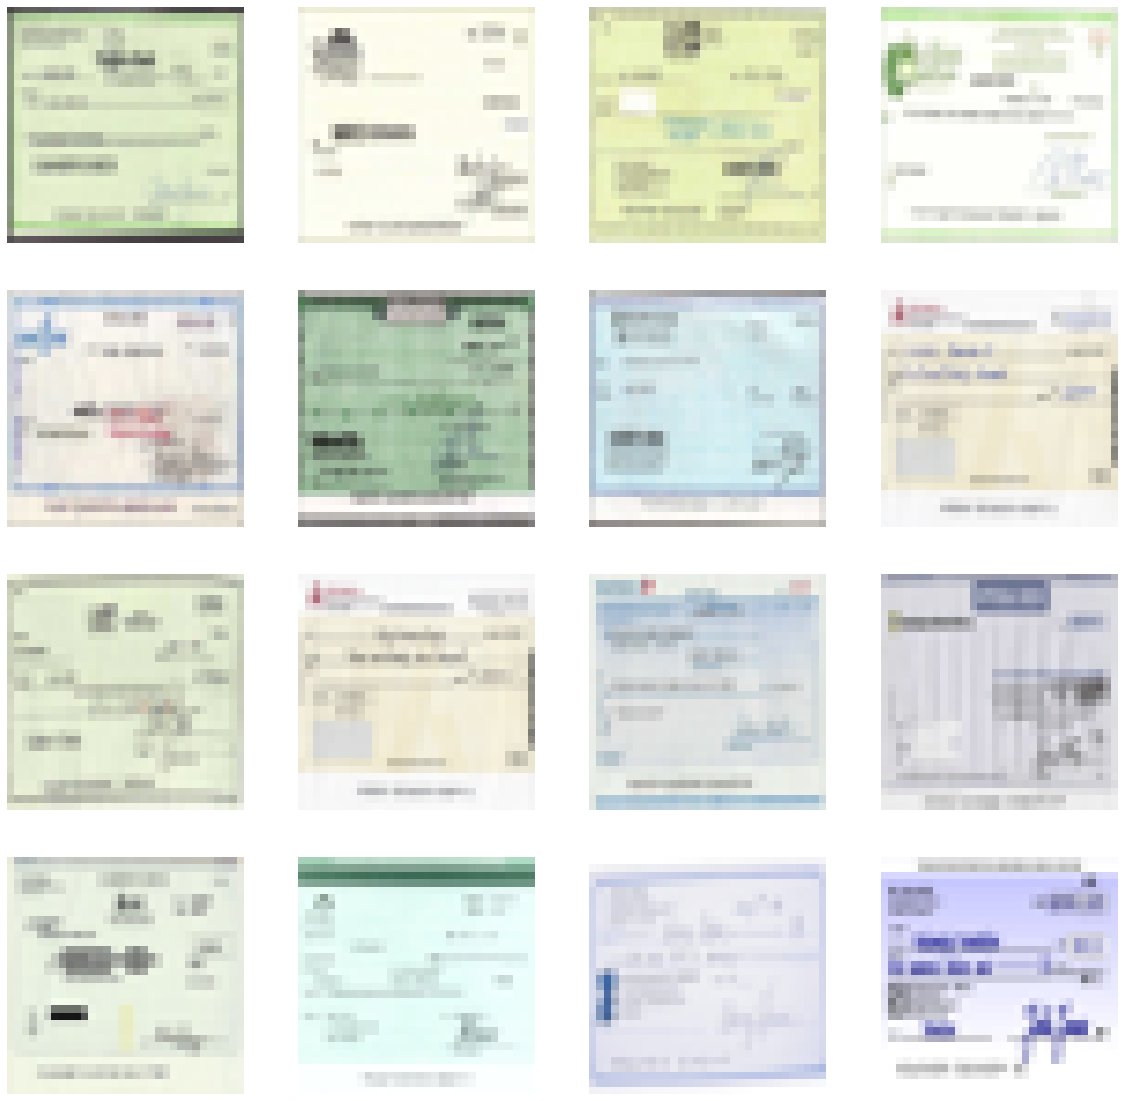

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
for i in np.arange(16):
    
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(c[i])

In [7]:
c.shape

(158, 32, 32, 3)

# Signatures

In [48]:
from io import BytesIO
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import boto3
import PIL
from PIL import Image
from io import BytesIO
s3_client = boto3.client('s3')
paginator = s3_client.get_paginator('list_objects_v2')
bucket = 'verafin-mitacs-yifu-chen'
key ='validation'

In [49]:
images=[]
variants=[]

In [50]:
pages = paginator.paginate(Bucket=bucket, Prefix=key)
for page in pages:
    for obj in page['Contents']:
        img_key=obj['Key']
        file_byte_string = s3_client.get_object(Bucket = bucket, Key=img_key)['Body'].read()
        im = Image.open(BytesIO(file_byte_string))
        im = im.resize((256,32))
        im = np.array(im)           
        if im.shape == (256,32,3):
            images.append(im)
        else:
            variants.append(im)

In [52]:
variants[0].shape

(32, 256, 3)

In [54]:
from io import BytesIO
import numpy as np
from urllib.parse import urlparse
import boto3
client = boto3.client("s3")

def to_s3_npy(data: np.array, s3_uri: str):
    # s3_uri looks like f"s3://{BUCKET_NAME}/{KEY}"
    bytes_ = BytesIO()
    np.save(bytes_, data, allow_pickle=True)
    bytes_.seek(0)
    parsed_s3 = urlparse(s3_uri)
    client.upload_fileobj(
        Fileobj=bytes_, Bucket=parsed_s3.netloc, Key=parsed_s3.path[1:]
    )
    return True

In [57]:
x = np.array(variants)

In [58]:
x.shape

(4663, 32, 256, 3)

In [59]:
to_s3_npy(x, 's3://verafin-mitacs-yifu-chen/32_256_signature/')

True

In [96]:
def from_s3_npy(s3_uri: str):
    bytes_ = BytesIO()
    parsed_s3 = urlparse(s3_uri)
    client.download_fileobj(
        Fileobj=bytes_, Bucket=parsed_s3.netloc, Key=parsed_s3.path[1:]
    )
    bytes_.seek(0)
    return np.load(bytes_, allow_pickle=True)

In [5]:
c = from_s3_npy('s3://verafin-mitacs-yifu-chen/validation_31_248/')

In [7]:
c[3930].shape

(31, 284, 3)

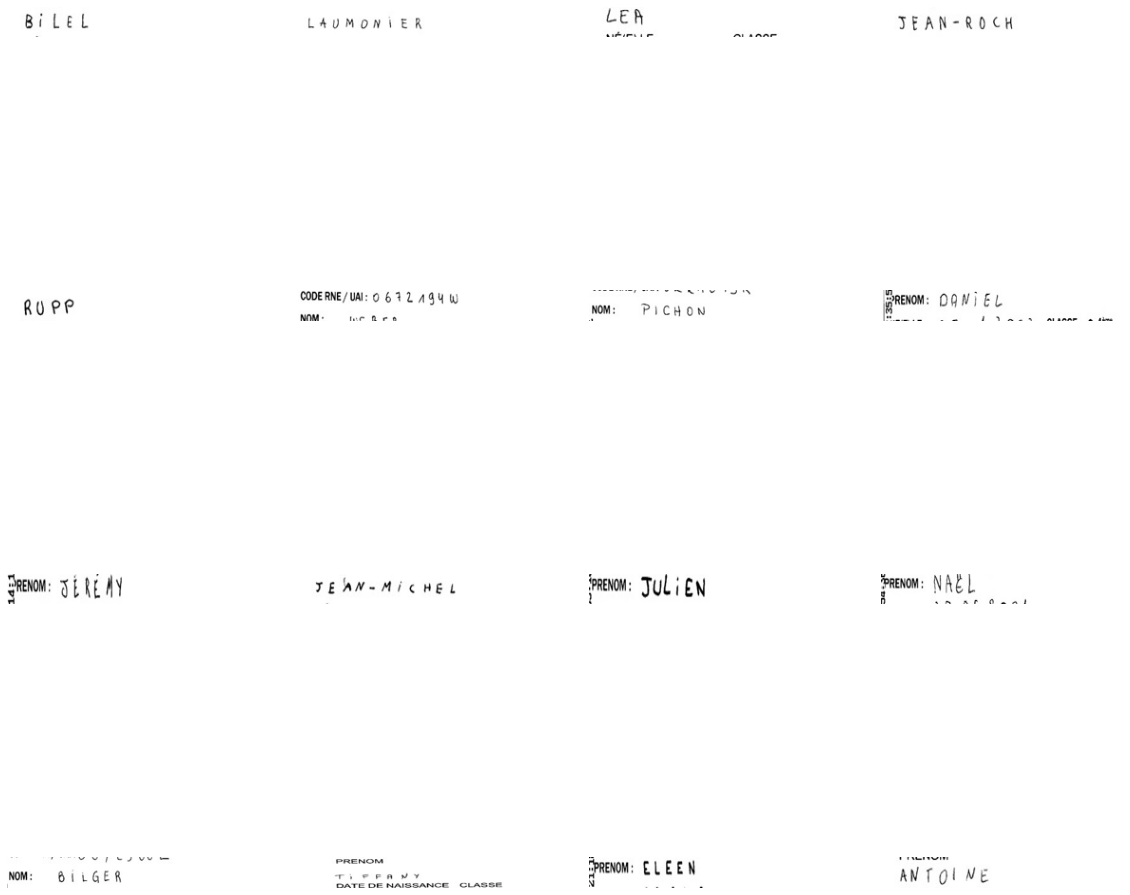

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
for i in np.arange(16):
    
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(variants[i])

# GAN

In [73]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU,Reshape,Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [61]:
def discriminator(in_shape=(32,256,3)):
    model=Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #dowmsampling
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #downsampling
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #downsampling
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    #compile
    optimization = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimization, metrics=['acc'])
    
    return model

In [60]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 256, 64)       1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 256, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 128, 128)      73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 128, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 64, 128)        147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 64, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 32, 256)       

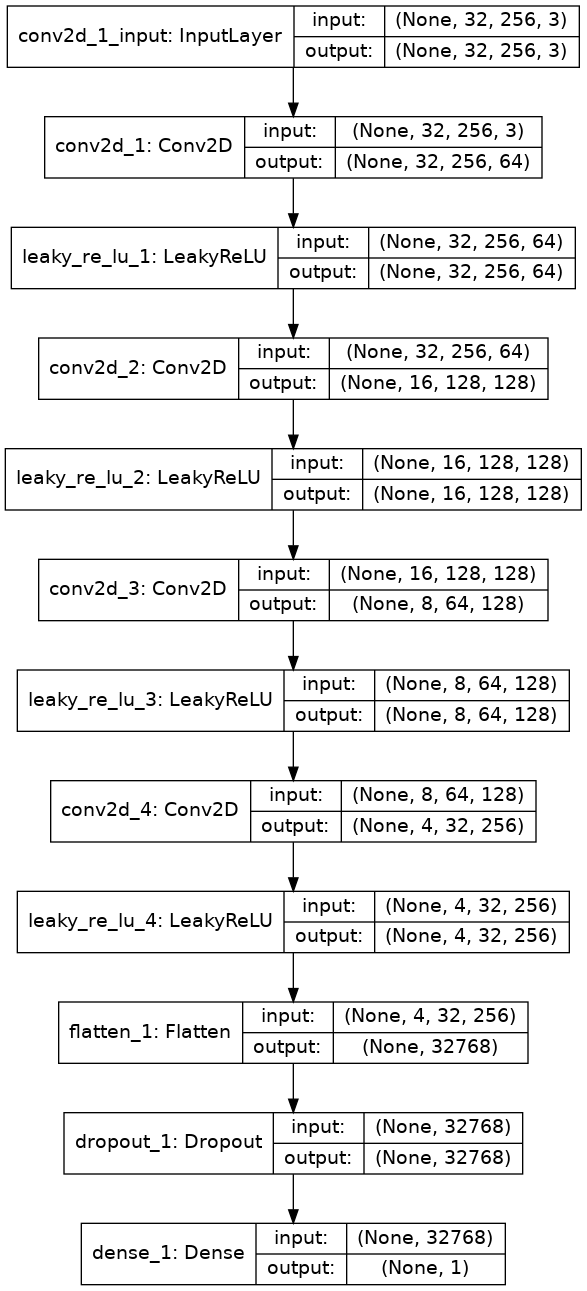

In [62]:
model = discriminator()
model.summary()

plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
#select real samples
def generate_real_samples(dataset, n_samples):
    #choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    #retrieve selected images
    X=dataset[ix]
    #generate 'real' class labels (1)
    y=ones((n_samples, 1))
    return X, y

In [71]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [65]:
#generate n fake samples with class labels
def generate_fake_samples(n_samples):
    #genrate uniform random numbers in [0,1]
    X = rand(32**3*n_samples)
    #update to have the range[-1,1]
    X= -1 + X * 2
    #reshape into a batch of color images
    X=X.reshape((n_samples, 32, 32, 3))
    #generate 'fake' class labels(0)
    y = zeros((n_samples, 1))
    return X, y

In [100]:
#generate n fake samples with class labels for handwrinting
def generate_fake_samples(n_samples):
    #genrate uniform random numbers in [0,1]
    X = rand(32*256*3*n_samples)
    #update to have the range[-1,1]
    X= -1 + X * 2
    #reshape into a batch of color images
    X=X.reshape((n_samples, 32, 256, 3))
    #generate 'fake' class labels(0)
    y = zeros((n_samples, 1))
    return X, y

In [67]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    #manually enumerate eopchs
    for i in range(n_iter):
        #get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        #update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        #generate ' fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        #update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        #summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 32, 256)        0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 8, 64, 128)        524416    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 8, 64, 128)        0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 16, 128, 128)      262272    
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 16, 128, 128)    

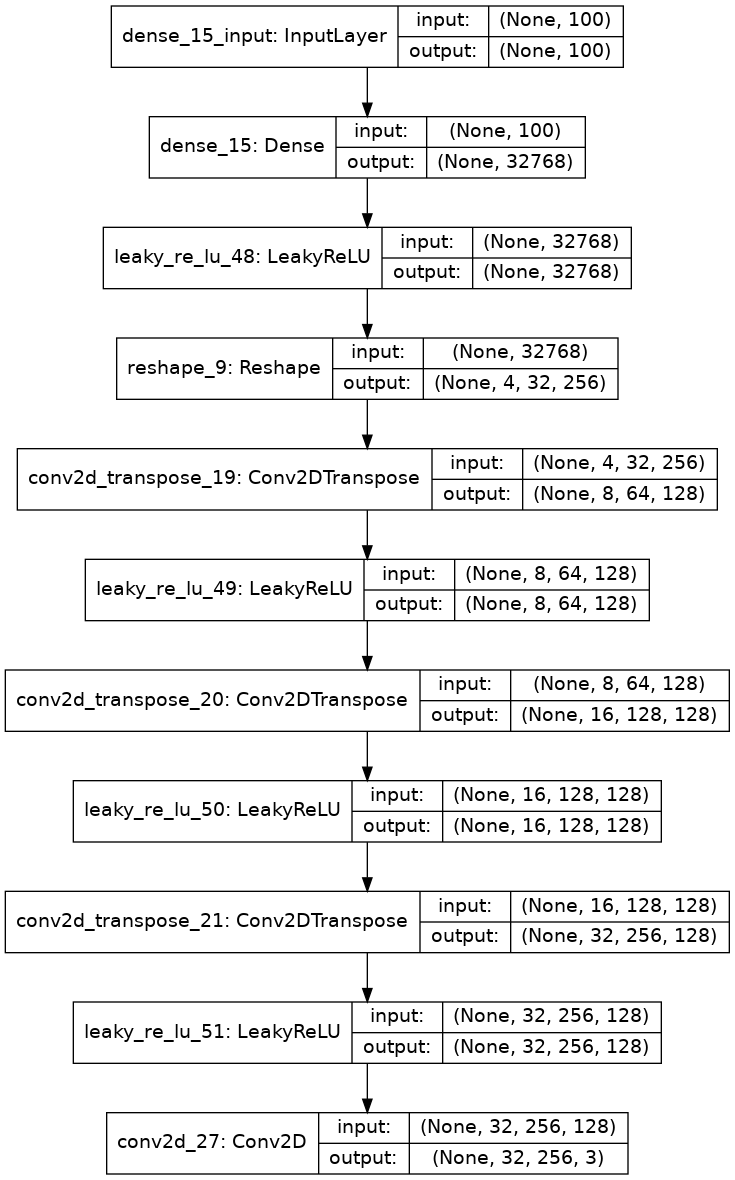

In [104]:
def generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 32
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,32,256)))
    #upsampling to 8 * 64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsampling to 16 * 128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsampling to 32 * 256
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

#define latent space
latent_dim = 100
model = generator(latent_dim)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)      

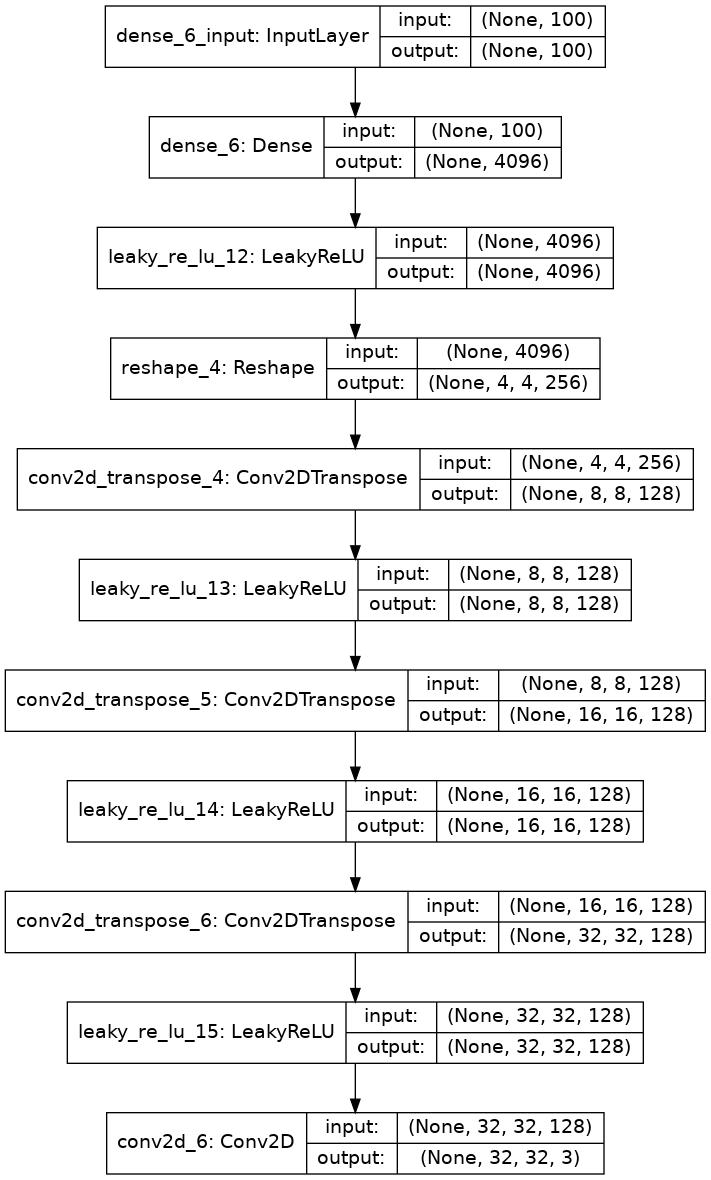

In [78]:
from numpy.random import randn
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
#a smaller low-resolution version of te image works better in a first dense layer
#foundation of 4 * 4 image

def generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    #upsampling to 8 * 8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsampling to 16 * 16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsampling to 32 * 32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

#define latent space
latent_dim = 100
model = generator(latent_dim)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [79]:
# generate point in the latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    #reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [102]:
# using the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in the latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    
    return X, y

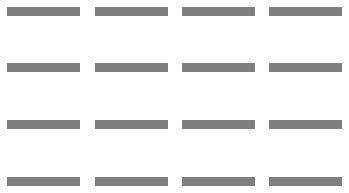

In [110]:
n_samples = 16
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1, 1 to [0,1]]
X = (X + 1)/ 2

for i in range(n_samples):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.imshow(X[i])

In [111]:
# define the combined generator and discriminator model, for updating the generator
def gan(g_model,d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add disriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 32, 256, 3)        4361987   
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 551169    
Total params: 4,913,156
Trainable params: 4,361,987
Non-trainable params: 551,169
_________________________________________________________________


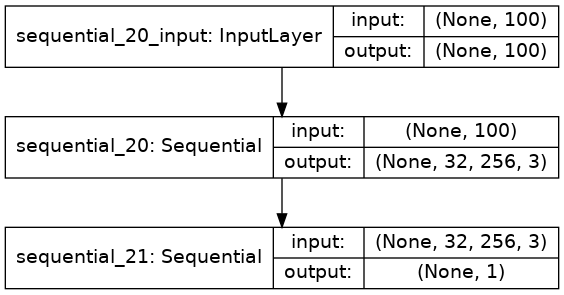

In [112]:
g_model = generator(latent_dim)
d_model = discriminator()
gan_model = gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [113]:
# train the composite model
# this is where you make the generated samples as real from the G
def train_gan(gan_model, latent_dim, n_epochs=20, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as inpt for the G
        x_gan = generate_latent_points(latent_dim, n_batch)
        #create inverted labels for the fake exmaples
        y_gan = ones((n_batch,1))
        # update the G via the D's error
        gan_model.train_on_batch(x_gan, y_gan)

* a few things to note in this model training function number of batches within an epoch is defined by how many times the batch size divides into the training dataset.
* the D model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combine the samples and performing a single update.
* Finally, we report the loss each batch. it is critical to keep an eye on the loss over batches. since a crash in the D loss indicates that the D model has started generating rubbish examples that the D can easily discriminate

In [114]:
# train the G and D
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update D model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate fake samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update D model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator 
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the D's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                 (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

# Evaluate GAN model performance

## there are three ways to hanfle the complex training situation
* Periodically evaluate the classification accuracy of the D on real and fake images
* Periodically generate many images and save them to file for subjective review
* peridocally save the G model 

### Firstly, we define a function that summarizes the performance of the D model. it does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR10 images with the G model. then evaluating the classification accuracy of the D on each sampleand reporting these erroes

In [115]:
# evaluate the D, plot generated images, save the G
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples= 150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate D on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake exmaples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate D on fake examples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize D performance
    print('>Accuracy real: %0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    #save plot
    save_plot(X_fake, epoch)
    # save the G model
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [116]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1, 1] to [0,1]
    examples = (examples + 1) /2
    fig = plt.figure(figsize=(20,20))
    # plot images
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(examples[i])
    # save plot to file

    filename = 'generator_plot_%03d.png' % (epoch + 1)
    plt.savefig(filename)
    plt.close()

# updated version of train

In [117]:
d_model.metrics_names

['loss', 'acc']

In [118]:
# train the G and D
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update D model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate fake samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update D model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator 
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the D's erroraccuracy
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                 (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [119]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=32):
    all_gl = np.array([]); all_dl1 = np.array([]); all_dl2 = np.array([])
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    
    start1 = time.time()
    
    for epoch in tqdm(range(n_epochs)):
        # enumerate batches over the training set
        start2 = time.time()
        
        G_loss = []; D_loss1 = []; D_loss2 = []
        
        for batch in range(bat_per_epo):
             # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update D model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate fake samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update D model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator 
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the D's erroraccuracy
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            
            #calculate G_loss and fake D_loss and real D_loss in each batch under each epoch and all epochs
            G_loss.append(g_loss); D_loss1.append(d_loss1); D_loss2.append(d_loss2)
            all_gl = np.append(all_gl,np.array([G_loss]))
            all_dl1 = np.append(all_dl1,np.array([D_loss1]))
            all_dl2 = np.append(all_dl2,np.array([D_loss2]))
            
            if batch % 1 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (batch, epoch, bat_per_epo, d_loss1, d_loss2, g_loss))
        
        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start2))
            
        # evaluate the model performance and plot losses
        if (epoch+1) % 10 == 0:
            summarize_performance(epoch, g_model, d_model, dataset, latent_dim)
            plot_losses(D_loss1, D_loss2, G_loss, all_gl, all_dl1, all_dl2, epoch+1)
    print('Mission completed:', time.time() - start1)

In [120]:
def plot_losses(d_loss1, d_loss2, g_loss, all_gl, all_dl1, all_dl2, n_epoch):
    plt.figure(figsize=(10,5))
    plt.title("Discriminator Loss - EPOCH {}".format(n_epoch))
    plt.plot(d_loss1,label="D1")
    plt.plot(d_loss2,label="D2")
    plt.plot(g_loss,label="G")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    #ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl1)),all_dl1,label='D1')
    plt.plot(np.arange(len(all_dl2)),all_dl2,label='D2')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

In [121]:
def load_real_samples():
    trainX = from_s3_npy('s3://verafin-mitacs-yifu-chen/32_256_signature/')#(trainX, _), (_,_) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    
    return X

In [122]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)

dataset = load_real_samples()

In [130]:
import glob
import imageio
anim_file = 'signature.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('generator_plot_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 50*(i**2)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    IPython.display.Image(filename=anim_file)

In [128]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2jivmoc0
  Running command git clone --filter=blob:none -q https://github.com/tensorflow/docs /tmp/pip-req-build-2jivmoc0
  Resolved https://github.com/tensorflow/docs to commit 6914e839f3b89d4d25c56277108ab2b8d1c18619
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=168608 sha256=23931476dee1043d52f0a1d85da31a1adf6e9cd2998aa5e192088f0862237725
  Stored in directory: /tmp/pip-ephem-wheel-cache-ytzpvrf7/wheels/27/ca/30/9fb73780f8e8eb5a8321ae35616b0e9609f33e6c6f4071e8dd
Successfully built tensorflow-docs
Note: you may need to restart the kernel to use updated packages.



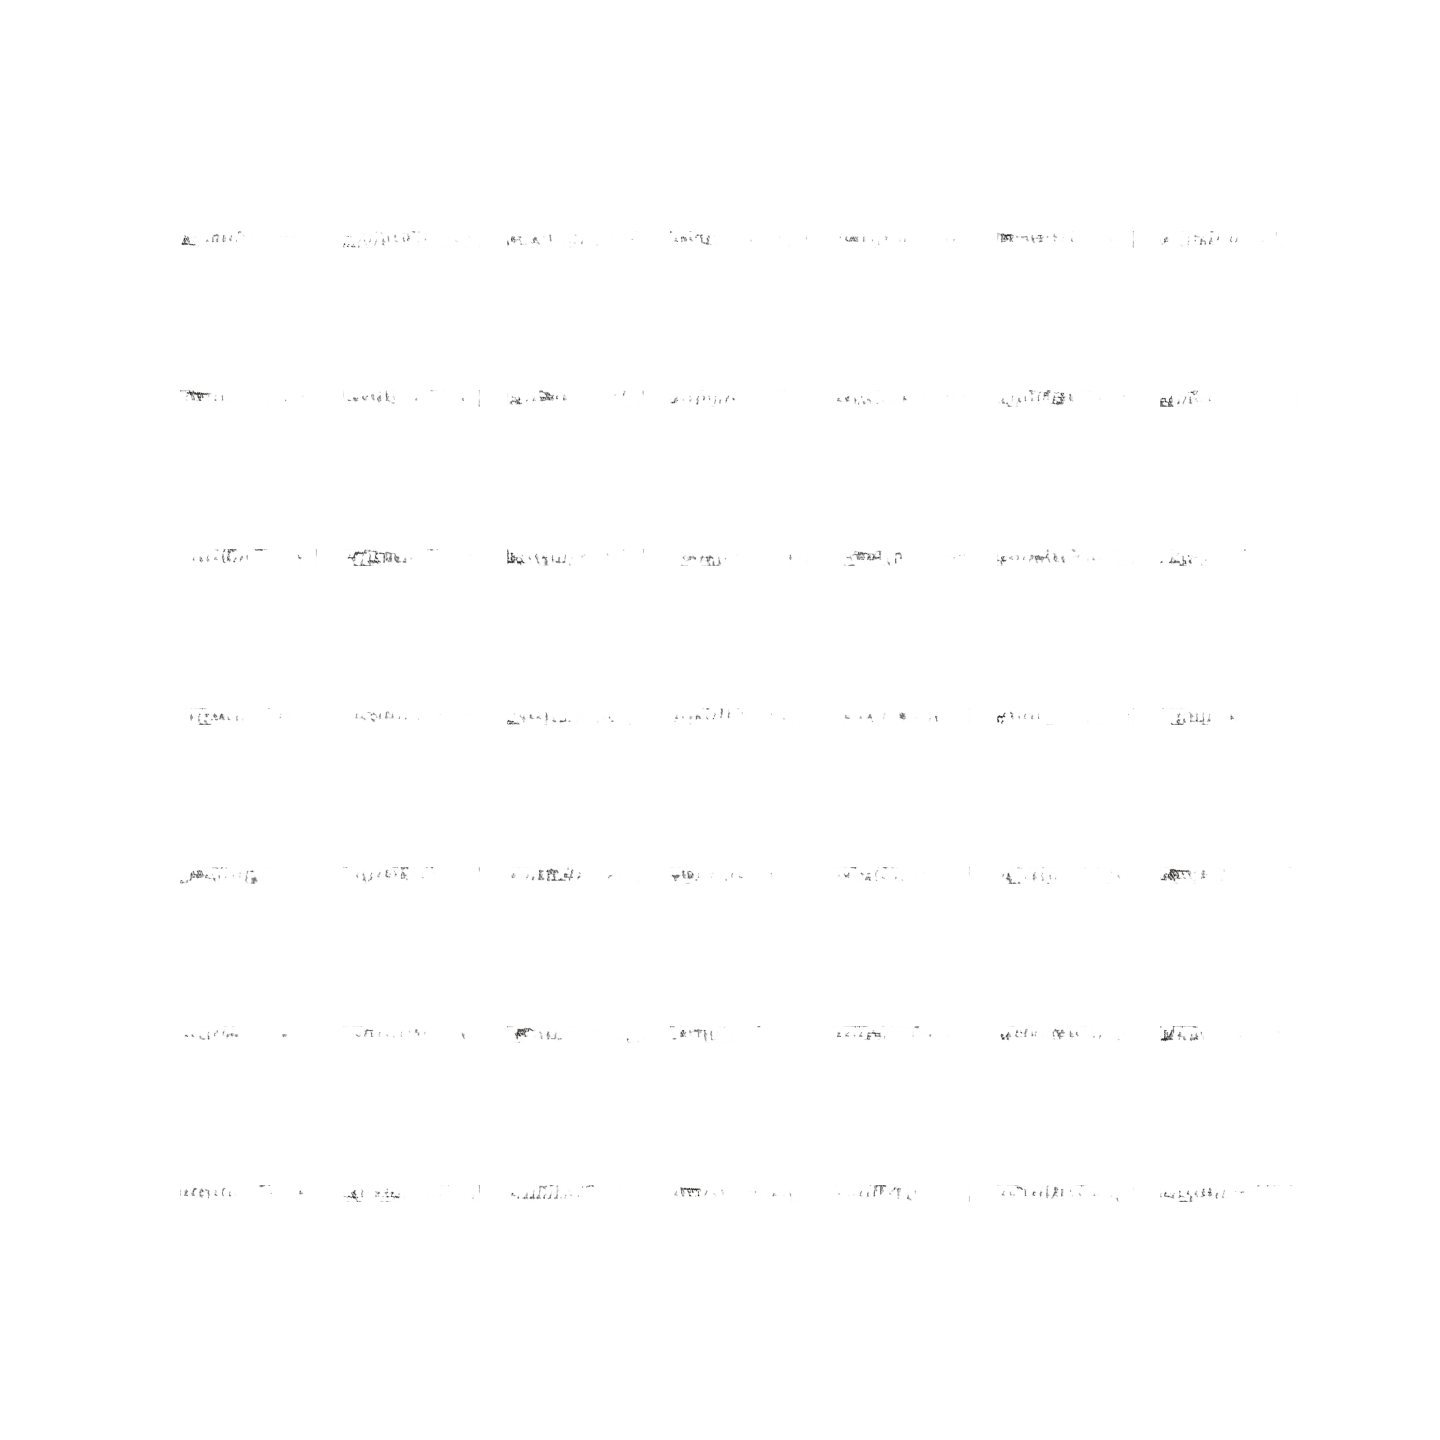

In [131]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>0, 0/145, d1=0.663, d2=0.696, g=0.692


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 0/145, d1=0.316, d2=0.698, g=0.691
>2, 0/145, d1=0.107, d2=0.703, g=0.688
>3, 0/145, d1=0.025, d2=0.713, g=0.681
>4, 0/145, d1=0.008, d2=0.732, g=0.669
>5, 0/145, d1=0.007, d2=0.763, g=0.653
>6, 0/145, d1=0.009, d2=0.791, g=0.639
>7, 0/145, d1=0.021, d2=0.822, g=0.649
>8, 0/145, d1=0.067, d2=0.869, g=0.652
>9, 0/145, d1=0.115, d2=0.945, g=0.633
>10, 0/145, d1=0.164, d2=1.030, g=0.620
>11, 0/145, d1=0.230, d2=1.031, g=0.615
>12, 0/145, d1=0.270, d2=0.959, g=0.644
>13, 0/145, d1=0.294, d2=0.884, g=0.732
>14, 0/145, d1=0.320, d2=0.751, g=0.814
>15, 0/145, d1=0.294, d2=0.713, g=0.900
>16, 0/145, d1=0.267, d2=0.651, g=0.985
>17, 0/145, d1=0.226, d2=0.612, g=1.118
>18, 0/145, d1=0.202, d2=0.561, g=1.148
>19, 0/145, d1=0.158, d2=0.602, g=1.287
>20, 0/145, d1=0.109, d2=0.530, g=1.268
>21, 0/145, d1=0.123, d2=0.850, g=0.940
>22, 0/145, d1=0.087, d2=0.973, g=0.735
>23, 0/145, d1=0.139, d2=0.979, g=0.651
>24, 0/145, d1=0.038, d2=0.801, g=0.915
>25, 0/145, d1=0.144, d2=0.642, g=1.088
>26, 0/14

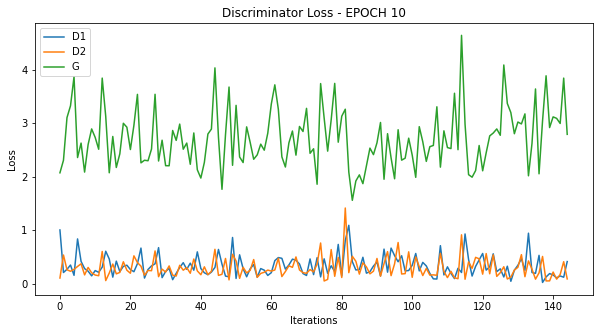

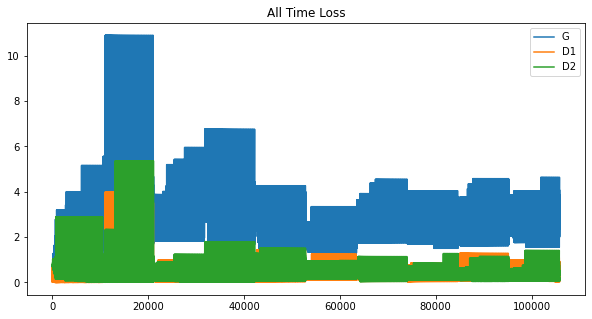

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>0, 10/145, d1=0.238, d2=0.277, g=2.190
>1, 10/145, d1=0.397, d2=0.652, g=2.790
>2, 10/145, d1=0.304, d2=0.262, g=3.410
>3, 10/145, d1=0.309, d2=0.129, g=3.187
>4, 10/145, d1=0.548, d2=0.889, g=2.731
>5, 10/145, d1=0.736, d2=0.136, g=2.192
>6, 10/145, d1=0.379, d2=1.043, g=3.361
>7, 10/145, d1=0.694, d2=0.070, g=3.212
>8, 10/145, d1=0.410, d2=0.227, g=2.463
>9, 10/145, d1=0.188, d2=0.139, g=2.798
>10, 10/145, d1=0.289, d2=0.188, g=3.228
>11, 10/145, d1=0.140, d2=0.118, g=2.879
>12, 10/145, d1=0.114, d2=0.141, g=3.572
>13, 10/145, d1=0.272, d2=0.108, g=2.811
>14, 10/145, d1=0.207, d2=0.160, g=2.262
>15, 10/145, d1=0.046, d2=0.330, g=2.747
>16, 10/145, d1=0.169, d2=0.181, g=3.282
>17, 10/145, d1=0.218, d2=0.233, g=2.395
>18, 10/145, d1=0.095, d2=0.334, g=2.729
>19, 10/145, d1=0.315, d2=0.353, g=2.364
>20, 10/145, d1=0.237, d2=0.469, g=3.035
>21, 10/145, d1=0.605, d2=0.425, g=2.377
>22, 10/145, d1=0.520, d2=0.690, g=2.272
>23, 10/145, d1=0.272, d2=0.410, g=3.348
>24, 10/145, d1=0.555, d2=

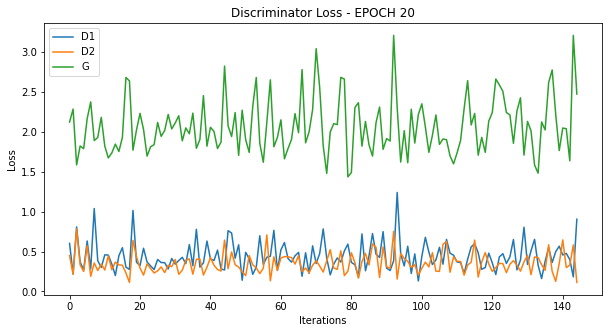

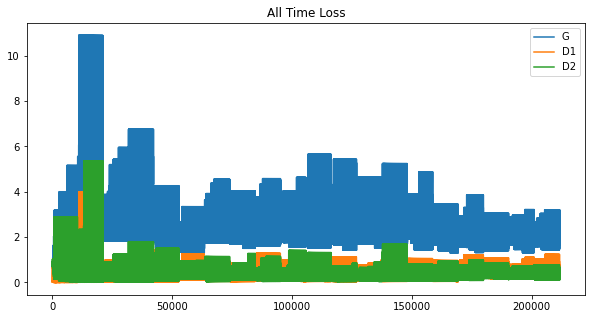

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>0, 20/145, d1=0.558, d2=0.340, g=1.650
>1, 20/145, d1=0.153, d2=0.313, g=1.863
>2, 20/145, d1=0.378, d2=0.244, g=1.837
>3, 20/145, d1=0.501, d2=0.373, g=1.690
>4, 20/145, d1=0.382, d2=0.413, g=1.914
>5, 20/145, d1=0.470, d2=0.361, g=1.865
>6, 20/145, d1=0.207, d2=0.245, g=2.388
>7, 20/145, d1=0.354, d2=0.489, g=2.848
>8, 20/145, d1=0.635, d2=0.399, g=1.985
>9, 20/145, d1=0.464, d2=0.553, g=2.031
>10, 20/145, d1=0.379, d2=0.353, g=2.521
>11, 20/145, d1=0.942, d2=0.441, g=1.738
>12, 20/145, d1=0.609, d2=0.319, g=2.108
>13, 20/145, d1=0.463, d2=0.317, g=2.093
>14, 20/145, d1=0.270, d2=0.479, g=2.460
>15, 20/145, d1=0.742, d2=0.317, g=1.663
>16, 20/145, d1=0.197, d2=0.277, g=2.080
>17, 20/145, d1=0.191, d2=0.353, g=2.196
>18, 20/145, d1=0.561, d2=0.290, g=2.099
>19, 20/145, d1=0.343, d2=0.515, g=1.876
>20, 20/145, d1=0.346, d2=0.470, g=2.163
>21, 20/145, d1=0.525, d2=0.262, g=2.299
>22, 20/145, d1=0.607, d2=0.540, g=2.424
>23, 20/145, d1=0.580, d2=0.281, g=1.962
>24, 20/145, d1=0.499, d2=

In [ ]:
from tqdm.notebook import trange, tqdm
import time
train(g_model, d_model, gan_model, dataset, latent_dim)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


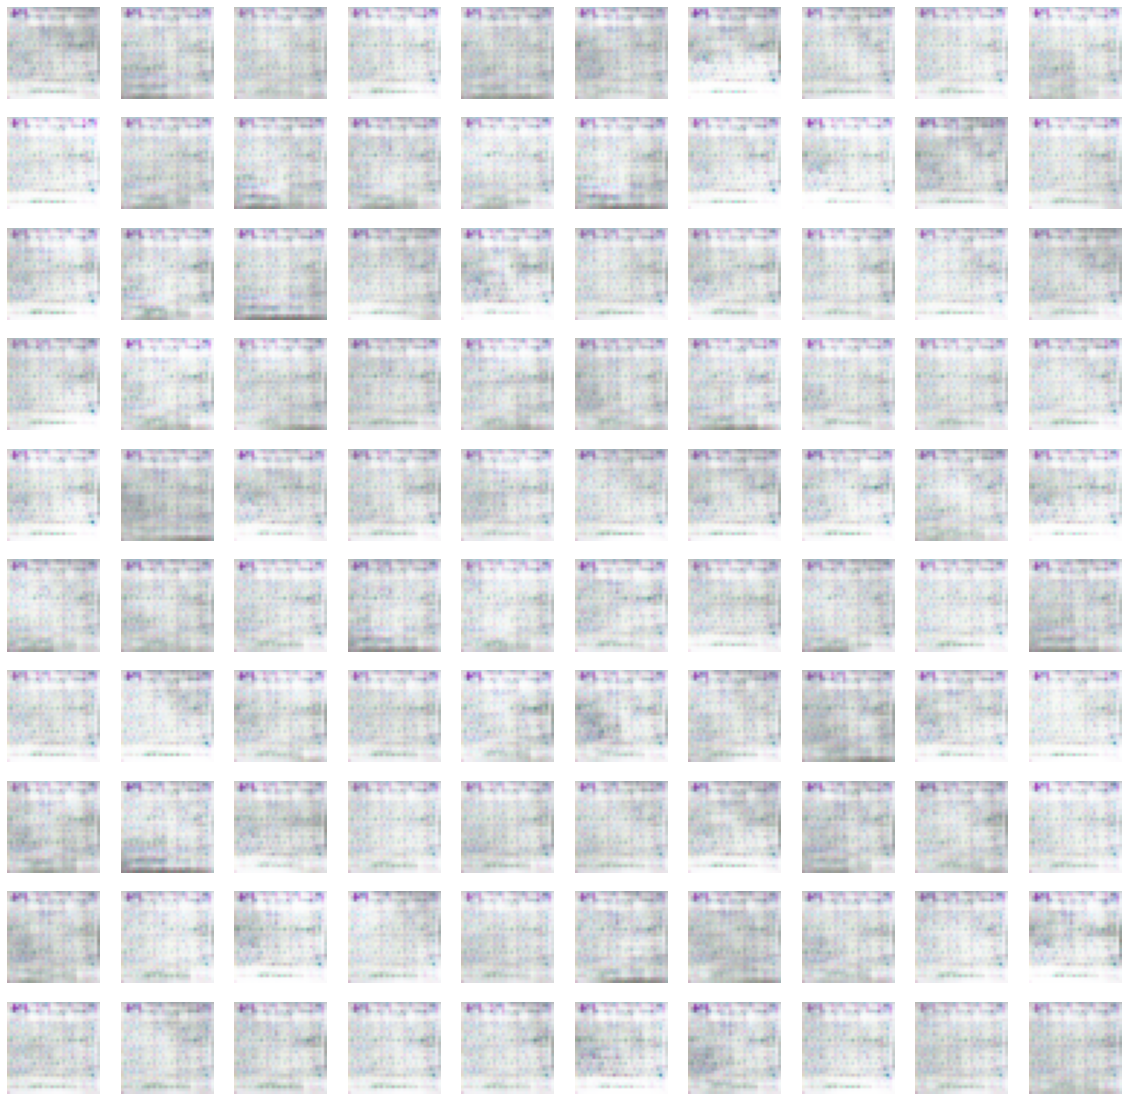

In [37]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn

 
# plot the generated images
def create_plot(examples, n):
    # plot images
    fig = plt.figure(figsize=(20,20))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

#load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)